In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
# URL tải xuống trực tiếp của tệp CSV trên Google Drive
url = 'https://drive.google.com/uc?export=download&id=12BJ35mvR5HbrelvjJznDtEQQ33zM7tdQ'

# Đọc tệp CSV từ URL
try:
    train = pd.read_csv(url)
    print(train.head())
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")
data = train.copy()

  essay_id                                          full_text  score
0  000d118  Many people have car where they live. The thin...      3
1  000fe60  I am a scientist at NASA that is discussing th...      3
2  001ab80  People always wish they had the same technolog...      4
3  001bdc0  We all heard about Venus, the planet without a...      4
4  002ba53  Dear, State Senator\n\nThis is a letter to arg...      3


In [3]:
# Hiển thị thông tin cơ bản
data_info = data.info()
# Hiển thị 5 hàng đầu tiên
data_head = data.head()
# Thống kê mô tả
data_describe = data.describe()
data_info, data_head, data_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


(None,
   essay_id                                          full_text  score
 0  000d118  Many people have car where they live. The thin...      3
 1  000fe60  I am a scientist at NASA that is discussing th...      3
 2  001ab80  People always wish they had the same technolog...      4
 3  001bdc0  We all heard about Venus, the planet without a...      4
 4  002ba53  Dear, State Senator\n\nThis is a letter to arg...      3,
               score
 count  17307.000000
 mean       2.948402
 std        1.044899
 min        1.000000
 25%        2.000000
 50%        3.000000
 75%        4.000000
 max        6.000000)

Thông tin cơ bản về dữ liệu

Số lượng hàng: 17,307

Số lượng cột: 3

Tên các cột và kiểu dữ liệu:

essay_id (object)

full_text (object)

score (int64)

In [4]:
# Kiểm tra các giá trị bị thiếu
missing_values = data.isnull().sum()
missing_values

essay_id     0
full_text    0
score        0
dtype: int64

Nhận xét: Không có giá trị nào bị thiếu (nghe hơi vô tri)

### Nhận xét Phân phối cột score (kết hợp biểu đồ của Meomeo)

In [5]:
score = data['score'].value_counts()
score_describe = data['score'].describe()

score, score_describe

(score
 3    6280
 2    4723
 4    3926
 1    1252
 5     970
 6     156
 Name: count, dtype: int64,
 count    17307.000000
 mean         2.948402
 std          1.044899
 min          1.000000
 25%          2.000000
 50%          3.000000
 75%          4.000000
 max          6.000000
 Name: score, dtype: float64)

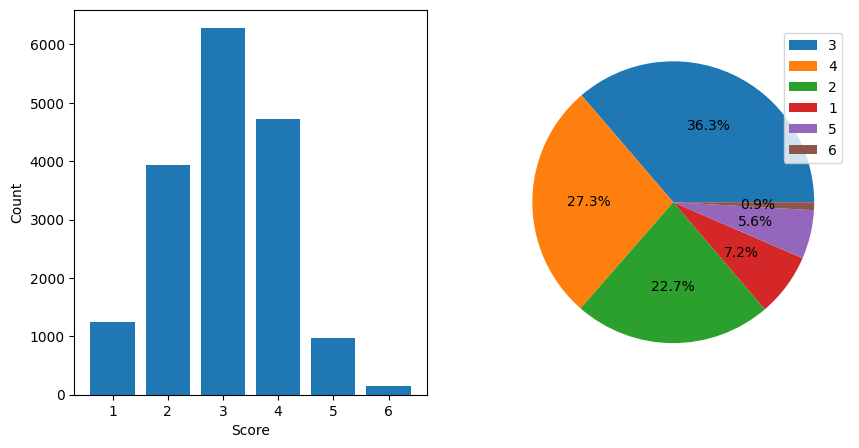

In [6]:
# ti le phan bo diem
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(data['score'].unique(), data['score'].value_counts())
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Count')

ax[1].pie(data['score'].value_counts(), autopct='%1.1f%%')
ax[1].legend(labels = data['score'].unique(), loc = 'upper right')
plt.show()

Nhận xét:

- Số lượng các bài đạt điểm tối đa không cao, ít hơn 10 lần bài đạt điểm 1 và gần 60 lần bài đạt điểm trung bình
- Điểm có số lượng bài đạt được nhiều nhất là 3
- Khoảng điểm [2-4] chiếm số lượng nhiều hơn các khác còn lại

### Tạo thêm cột `high_score`
Để thuận tiện hơn trong quá trình khám phá dữ liệu cũng như kết hợp với một số kiểm định, ta sẽ gom dữ liệu thành 2 nhóm và tạo thêm cột `high_score`, cụ thể:
  + Các bài đạt điểm 1, 2 và 3 sẽ chung một nhóm với giá trị cột `high_score` = 0
  + Các bài đạt điểm 4, 5 và 6 sẽ chung một nhóm với giá trị cột `high_score` = 1

In [7]:
data['high_score'] = data['score'].apply(lambda x: 0 if x in [1, 2, 3] else (1 if x in [4, 5, 6] else None))
data.head()

,essay_id,full_text,score,high_score
0,000d118,Many people have car where they live. The thin...,3,0
1,000fe60,I am a scientist at NASA that is discussing th...,3,0
2,001ab80,People always wish they had the same technolog...,4,1
3,001bdc0,"We all heard about Venus, the planet without a...",4,1
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0


### Độ dài essay aka số lượng ký tự (bổ sung thêm dựa trên Meomeo)

In [8]:
# Tạo thêm cột mới
data['len_text'] = data['full_text'].str.len() ;
data.head()

,essay_id,full_text,score,high_score,len_text
0,000d118,Many people have car where they live. The thin...,3,0,2677
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669
2,001ab80,People always wish they had the same technolog...,4,1,3077
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208


In [9]:
character_number_describe = data['len_text'].describe()
character_number_describe

count    17307.000000
mean      2071.617265
std        925.910701
min        712.000000
25%       1397.000000
50%       1924.000000
75%       2541.000000
max      20459.000000
Name: len_text, dtype: float64

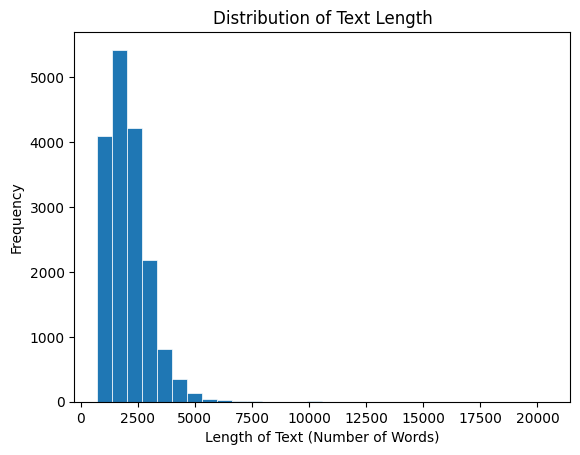

In [10]:
plt.hist(data['len_text'], bins=30, edgecolor='w', linewidth=0.5)
plt.xlabel('Length of Text (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

Hàm vẽ đồ thị histogram cho mỗi điểm ứng với một số đặc trưng của bài văn

In [11]:
def histogram_each_score(data, column_name, title):
    # Unique scores and number of scores
    unique_scores = sorted(data['score'].unique())
    num_scores = len(unique_scores)

    # Create subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True)
    fig.tight_layout(pad=5.0)

    for i, score in enumerate(unique_scores):
        row = i // 3
        col = i % 3
        score_data = data[data['score'] == score]
        mean_char_count = score_data[column_name].mean()
        std_char_count = score_data[column_name].std()

        axes[row, col].hist(score_data[column_name], bins=30, edgecolor='black', alpha=0.7)
        axes[row, col].axvline(mean_char_count, color='r', linestyle='dashed', linewidth=1)
        axes[row, col].axvline(mean_char_count + std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[row, col].axvline(mean_char_count - std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[row, col].set_title(f'Score: {score} (mean={mean_char_count:.2f}, sd={std_char_count:.2f})')
        axes[row, col].set_xlabel(title)
        axes[row, col].set_ylabel('Frequency')

    # Turn off unused subplots
    for j in range(num_scores, 9):
        row = j // 3
        col = j % 3
        fig.delaxes(axes[row, col])

    plt.show()

Hàm vẽ histogram và distribution dựa trên cột `high_score` và một đặc trưng khác

In [12]:
def chart_high_score(data, column_name, title):
    unique_scores = sorted(data['high_score'].unique())
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

    for i, score in enumerate(unique_scores):
        high_score_data = data[data['high_score'] == score]
        mean_char_count = high_score_data[column_name].mean()
        std_char_count = high_score_data[column_name].std()

        axes[i].hist(high_score_data[column_name], bins=30, edgecolor='black', alpha=0.7)
        axes[i].axvline(mean_char_count, color='r', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_char_count + std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_char_count - std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'Score: {score} (mean={mean_char_count:.2f}, sd={std_char_count:.2f})')
        axes[i].set_xlabel(title)
        axes[i].set_ylabel('Frequency')

    # Create the distribution plot in the third subplot
    sns.kdeplot(data=data, x=column_name, hue='high_score', palette=['red', 'green'], ax=axes[2])
    axes[2].set_title('Distribution of' + title + ' by Score')
    axes[2].set_xlabel(title)
    axes[2].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

Hàm kiểm định giả thuyết

In [13]:
from scipy import stats
def accreditation(data, column_name, type):
  alpha = 0.05
  t_statistic, p_value = stats.ttest_ind(data[data['high_score'] == 1][column_name], data[data['high_score'] == 0][column_name], alternative=type)

  print("t-statistic = ", t_statistic)


  print("p-value = ", p_value)
  if p_value <= alpha:
      print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
  else:
      print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

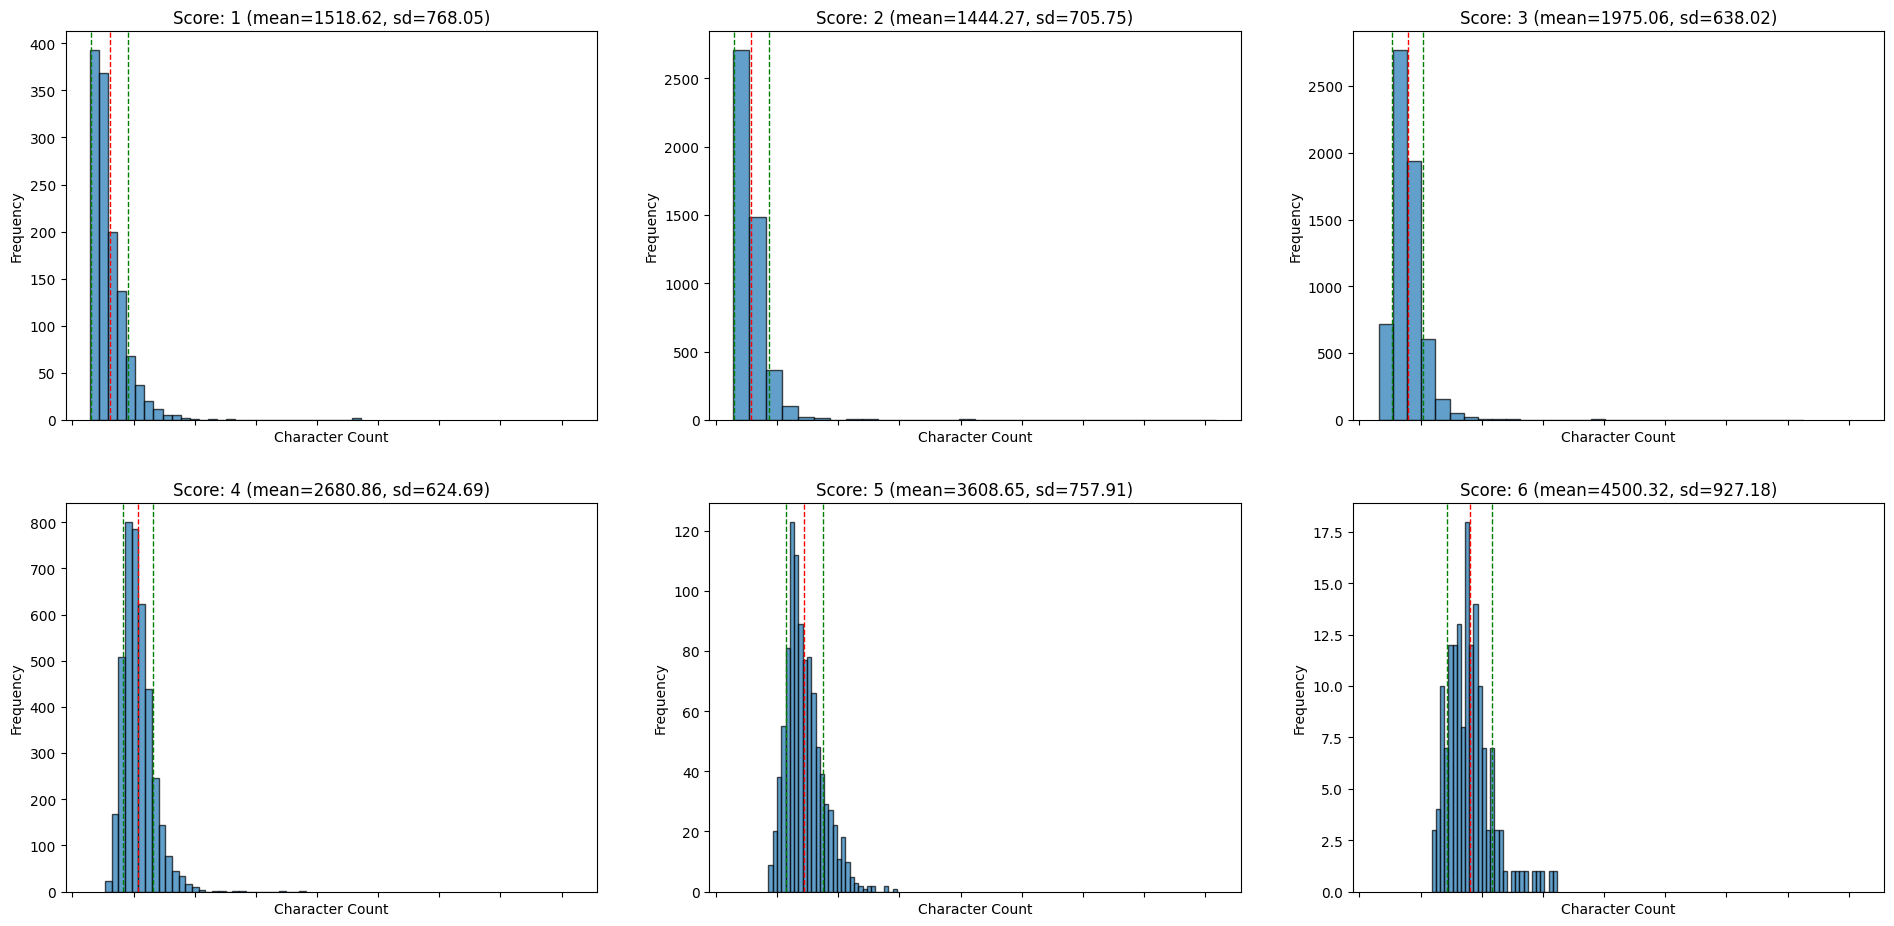

In [14]:
histogram_each_score(data, 'len_text', 'Character Count')

Nhận xét
  + Khi phân tích sự phân bố của các bài văn dựa theo từng mức điểm riêng lẻ thì đa phần các bài văn có đạt điểm 1, 2 và 3 có số lượng các ký tự ít hơn các bài văn đạt điểm 4, 5 và 6
    + Số lượng ký tự trung bình của bài văn đạt điểm 1 là: 1518.62
    + Số lượng ký tự trung bình của bài văn đạt điểm 2 là: 1444.27
    + Số lượng ký tự trung bình của bài văn đạt điểm 3 là: 1975.06
    + Số lượng ký tự trung bình của bài văn đạt điểm 4 là: 2680.86
    + Số lượng ký tự trung bình của bài văn đạt điểm 5 là: 3608.65
    + Số lượng ký tự trung bình của bài văn đạt điểm 6 là: 4500.32


Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng ký tự nhiều hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng ký tự không nhiều hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng ký tự nhiều hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [15]:
accreditation(data, 'len_text',"greater")

t-statistic =  94.87915033946292
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Do đó, ta có thể kết luận rằng các bài văn thuộc nhóm `high_score` = 1 (bài văn đạt điểm 4, 5, 6) có số lượng ký tượng nhiều hơn các bài thuộc nhóm còn lại (bài văn đạt điểm 1, 2, 3) với độ tin cậy 95%

### Số lượng từ

In [16]:
def word_count(df):
    df = df.split()
    return len(df)

data['word_count'] = data['full_text'].agg(word_count)

In [17]:
data.head()

,essay_id,full_text,score,high_score,len_text,word_count
0,000d118,Many people have car where they live. The thin...,3,0,2677,498
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669,332
2,001ab80,People always wish they had the same technolog...,4,1,3077,550
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701,451
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208,373


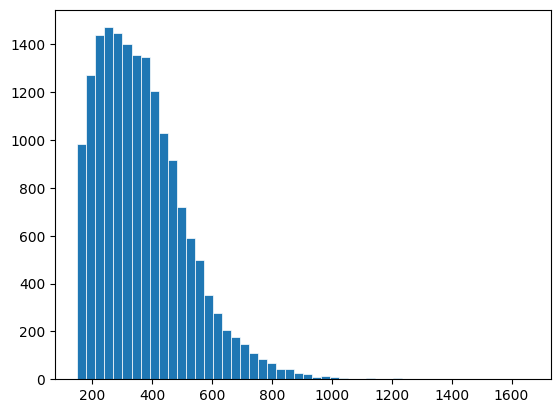

In [18]:
plt.hist(data['word_count'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()

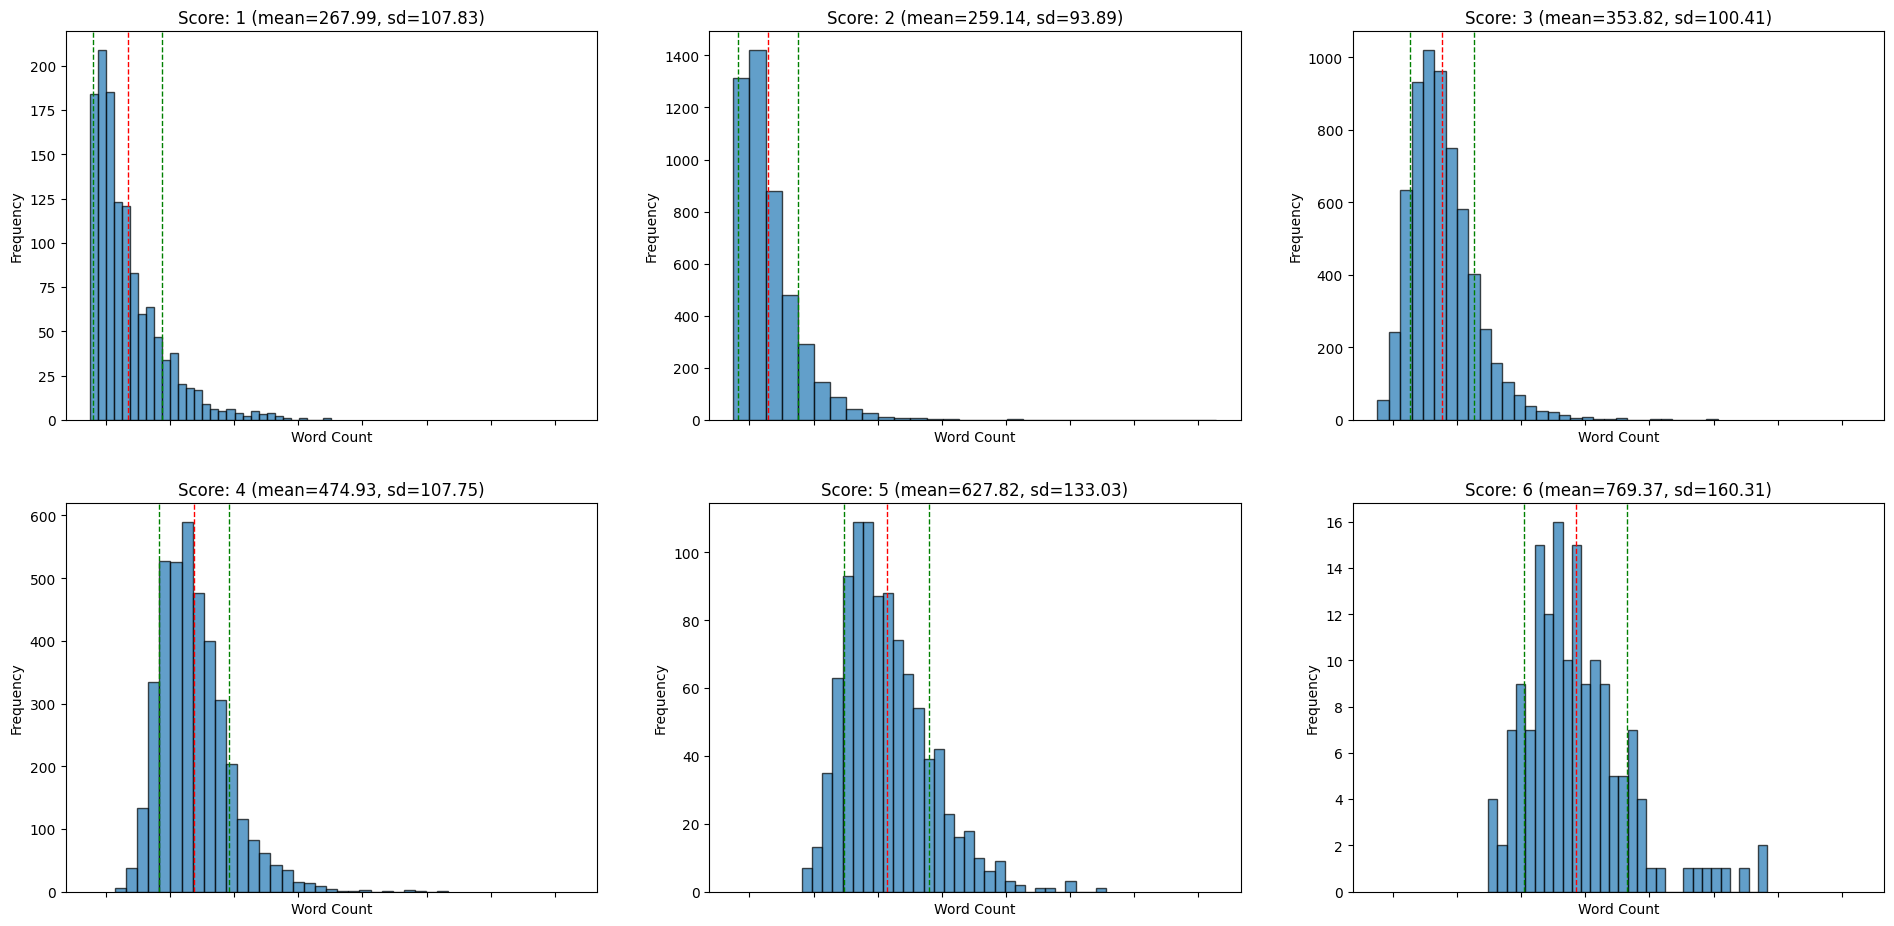

In [19]:
histogram_each_score(data, 'word_count', 'Word Count')

Nhận xét:
- Ta thấy giá trị trung bình số từ của điểm 1 2 3 đều nhỏ hơn điểm 4 5 6
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về số lượng từ của các bài văn

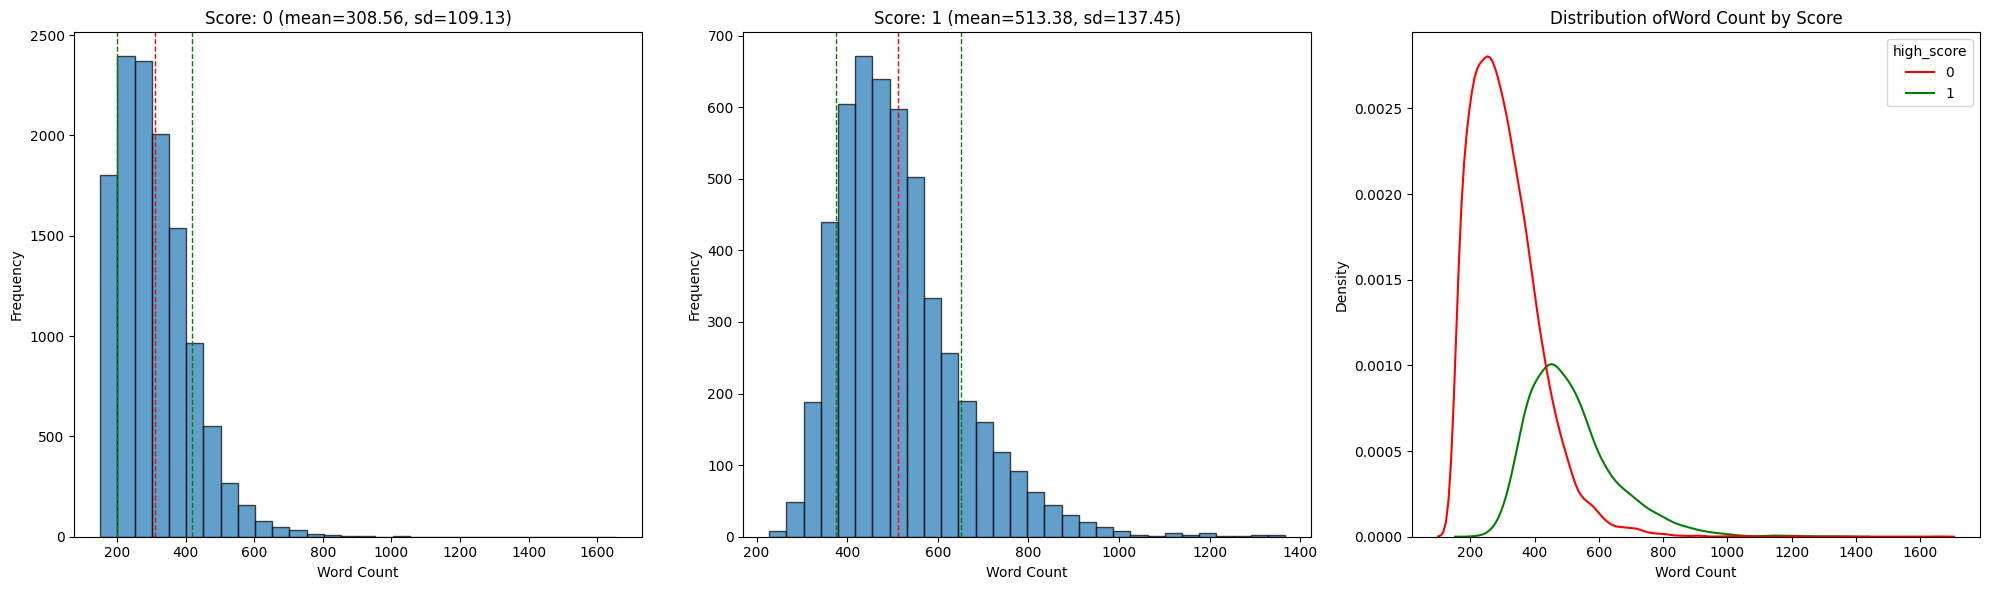

In [20]:
chart_high_score(data,'word_count', 'Word Count')

Nhận xét:
- Số lượng từ trung bình của nhóm điểm 1, 2, 3 lớn hơn số lượng từ trung bình của nhóm điểm 4, 5, 6
- Tuy nhiên, về mặt phân phối thì số lượng này lại theo chiều ngược lại

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng từ nhiều hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng từ không nhiều hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng từ nhiều hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [21]:
accreditation(data, 'word_count',"greater")

t-statistic =  103.72666484308634
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


### Số lượng câu

In [22]:
# Hàm tính số câu trong một bài luận
def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)


# Tính số câu cho mỗi bài luận
data['sentence_count'] = data['full_text'].apply(count_sentences)

print(data[['essay_id', 'sentence_count']])
data['sentence_count'].describe()

      essay_id  sentence_count
0      000d118              13
1      000fe60              21
2      001ab80              24
3      001bdc0              20
4      002ba53              15
...        ...             ...
17302  ffd378d               9
17303  ffddf1f              26
17304  fff016d              15
17305  fffb49b              11
17306  fffed3e              11

[17307 rows x 2 columns]


count    17307.000000
mean        19.091813
std          8.656060
min          1.000000
25%         13.000000
50%         18.000000
75%         24.000000
max        133.000000
Name: sentence_count, dtype: float64

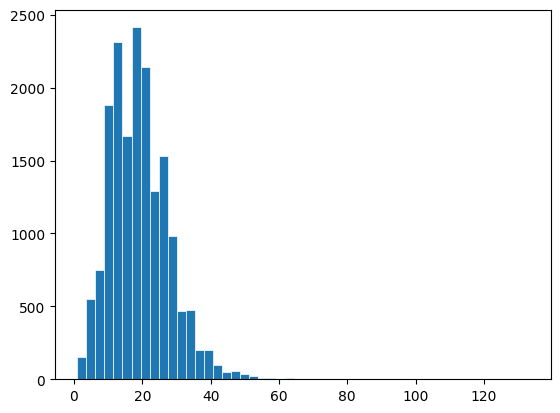

In [23]:
plt.hist(data['sentence_count'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()

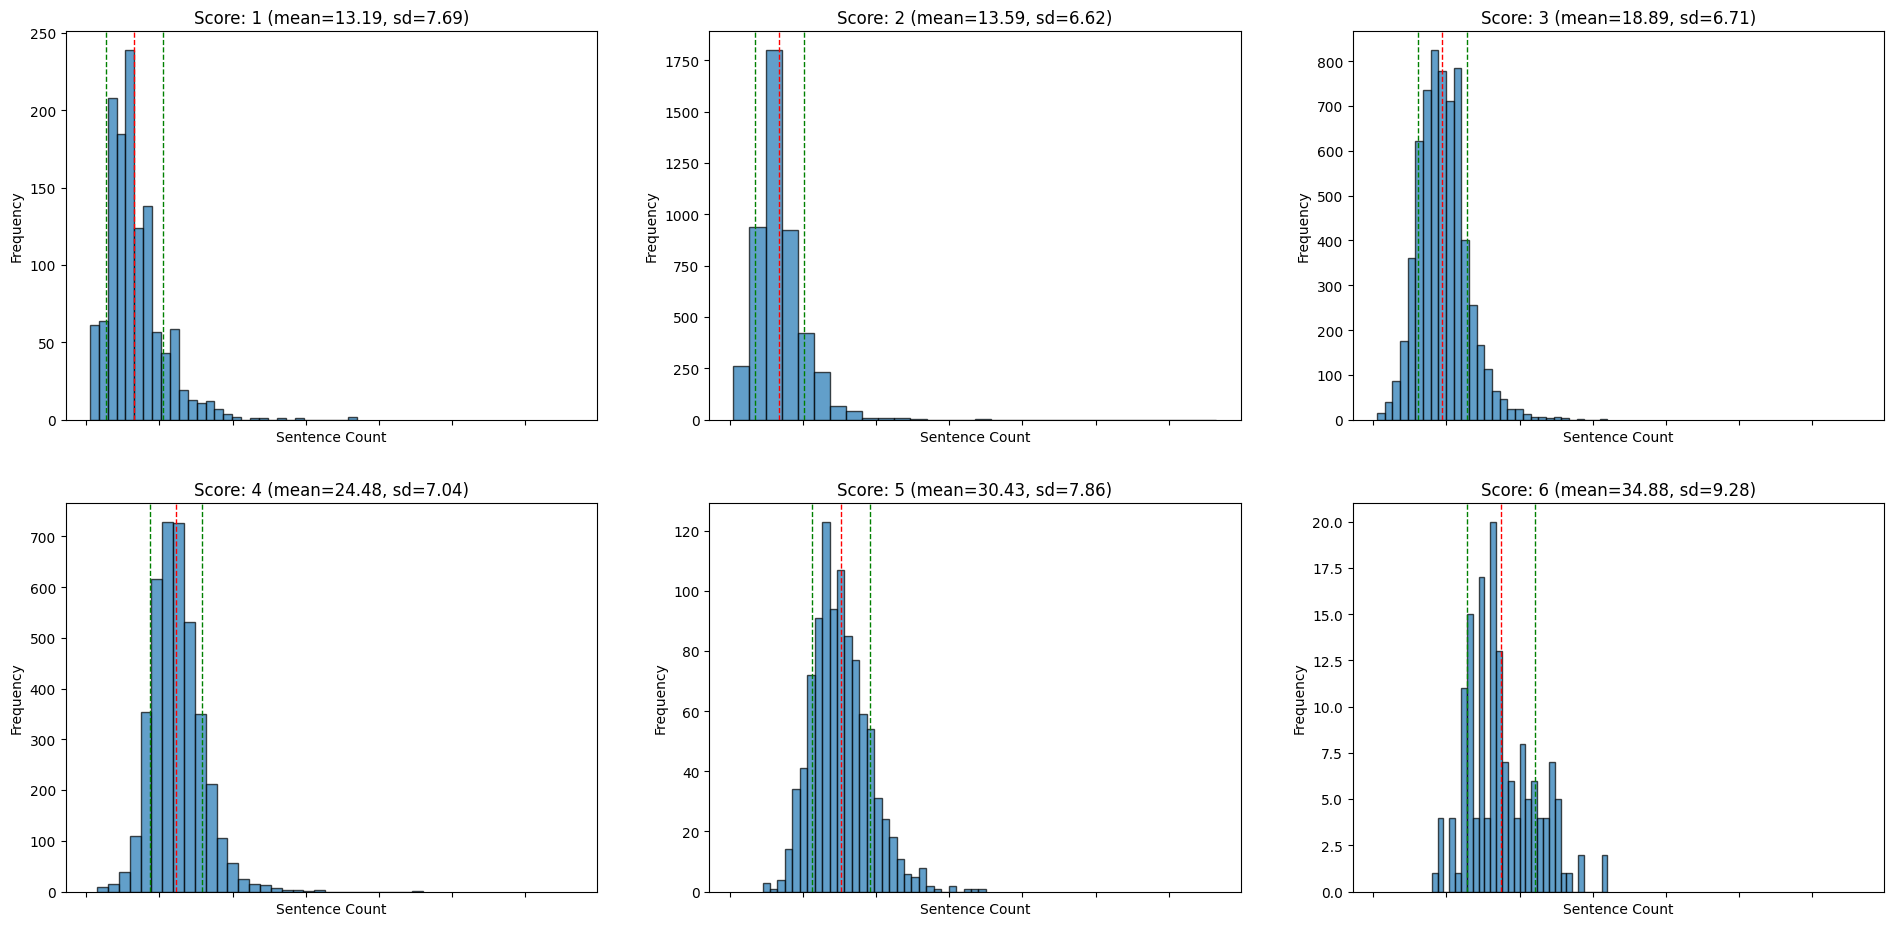

In [24]:
histogram_each_score(data, 'sentence_count', 'Sentence Count')

Nhận xét:
- Ta thấy số lượng câu trung bình của điểm 1 2 3 đều nhỏ hơn điểm 4 5 6
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về số lượng câu của các bài văn

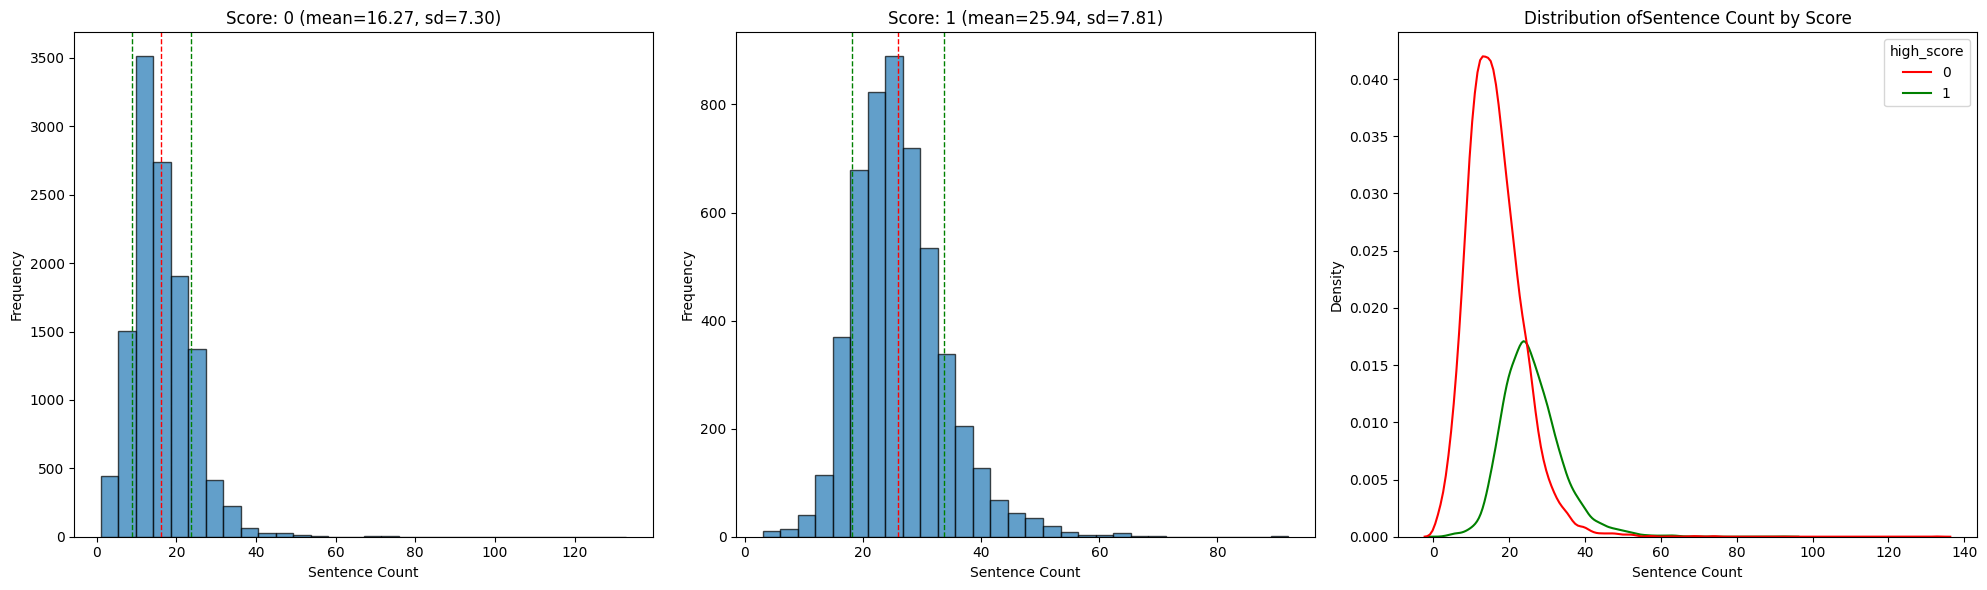

In [25]:
chart_high_score(data,'sentence_count', 'Sentence Count')

Nhận xét:
- Số lượng câu trung bình của nhóm điểm 1, 2, 3 lớn hơn số lượng câu trung bình của nhóm điểm 4, 5, 6
- Tuy nhiên, về mặt phân phối thì số lượng này lại theo chiều ngược lại

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng câu nhiều hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng câu không nhiều hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng câu nhiều hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [26]:
accreditation(data, 'sentence_count',"greater")

t-statistic =  77.6478478391825
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


### Số lượng đoạn văn

In [27]:
data['num_paragraphs'] = data['full_text'].apply(lambda x: x.count('\n') + 1)
data.head()

,essay_id,full_text,score,high_score,len_text,word_count,sentence_count,num_paragraphs
0,000d118,Many people have car where they live. The thin...,3,0,2677,498,13,1
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669,332,21,9
2,001ab80,People always wish they had the same technolog...,4,1,3077,550,24,7
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701,451,20,9
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208,373,15,11


In [28]:
data['num_paragraphs'].describe()

count    17307.000000
mean         8.930779
std          6.623264
min          1.000000
25%          5.000000
50%          9.000000
75%          9.000000
max        131.000000
Name: num_paragraphs, dtype: float64

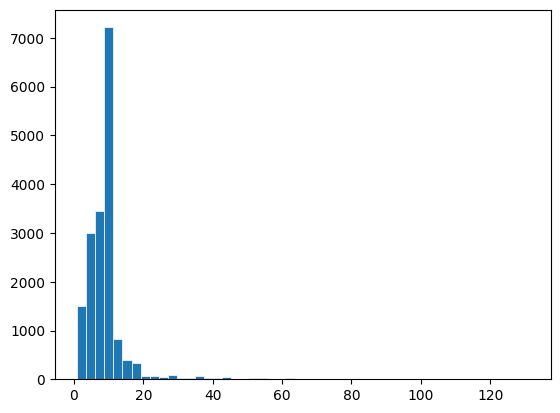

In [29]:
plt.hist(data['num_paragraphs'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()

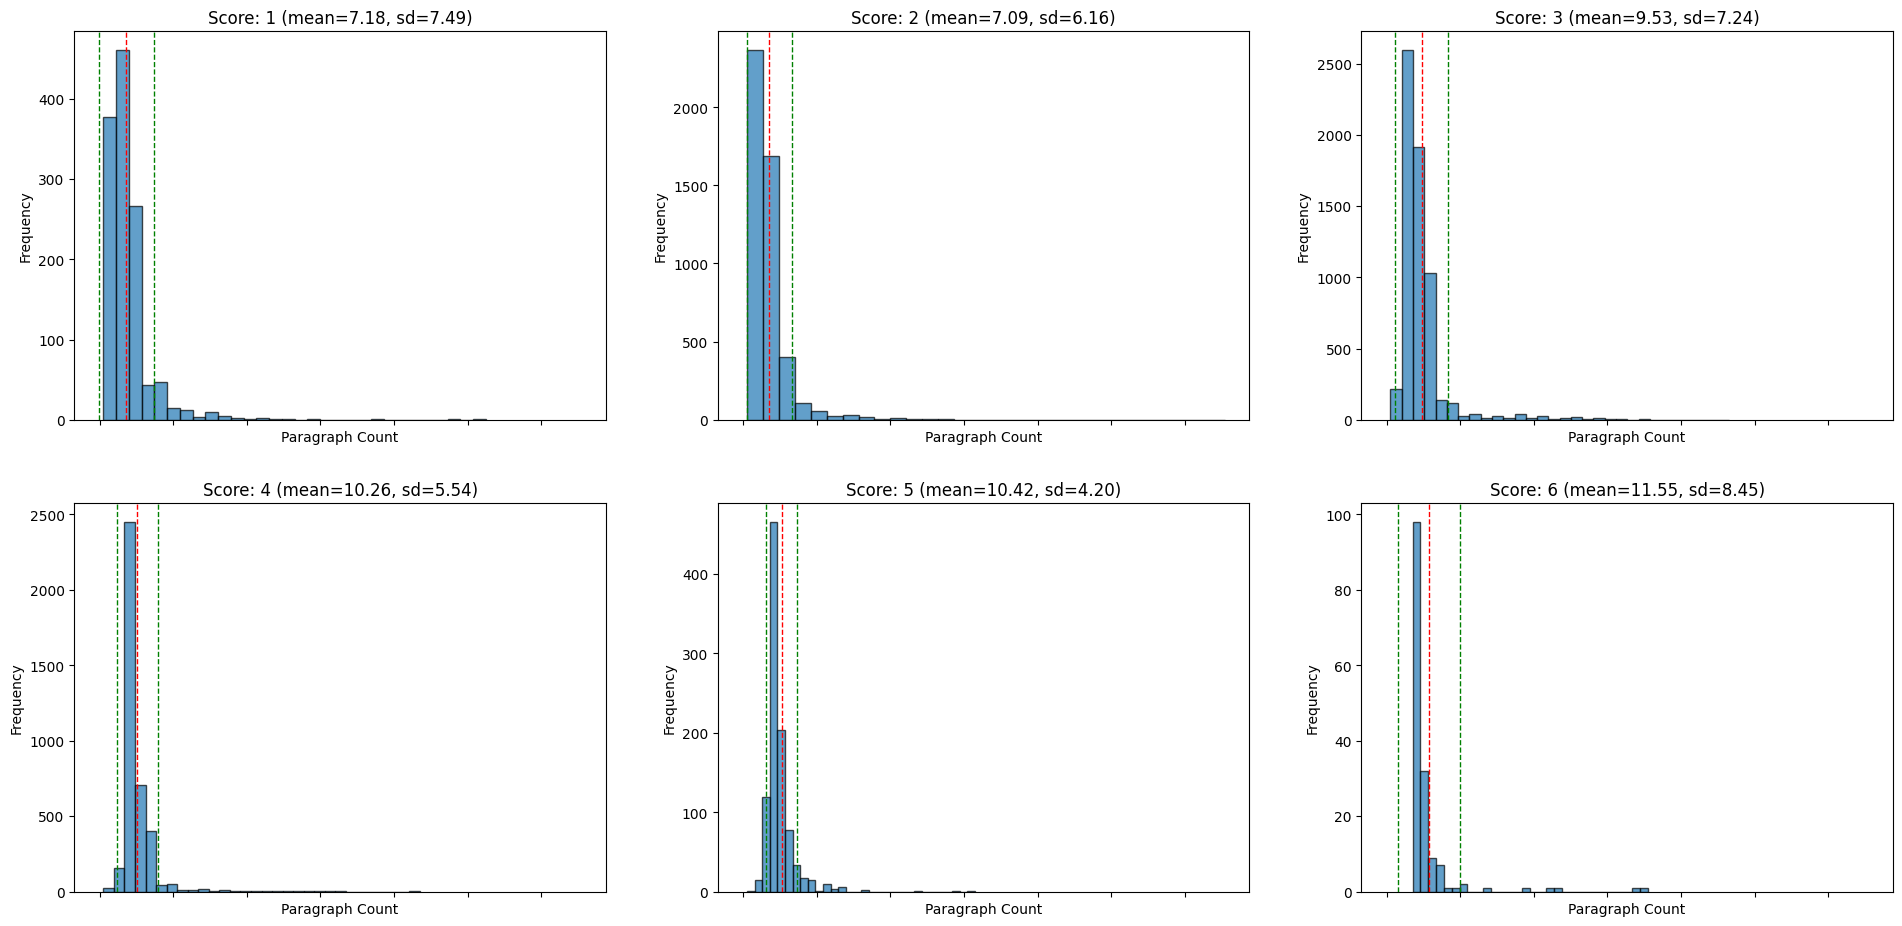

In [30]:
histogram_each_score(data, 'num_paragraphs', 'Paragraph Count')

Nhận xét:
- Ta thấy số lượng đoạn văn trung bình của điểm 1 2 3 đều nhỏ hơn điểm 4 5 6
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về số lượng đoạn văn của các bài văn

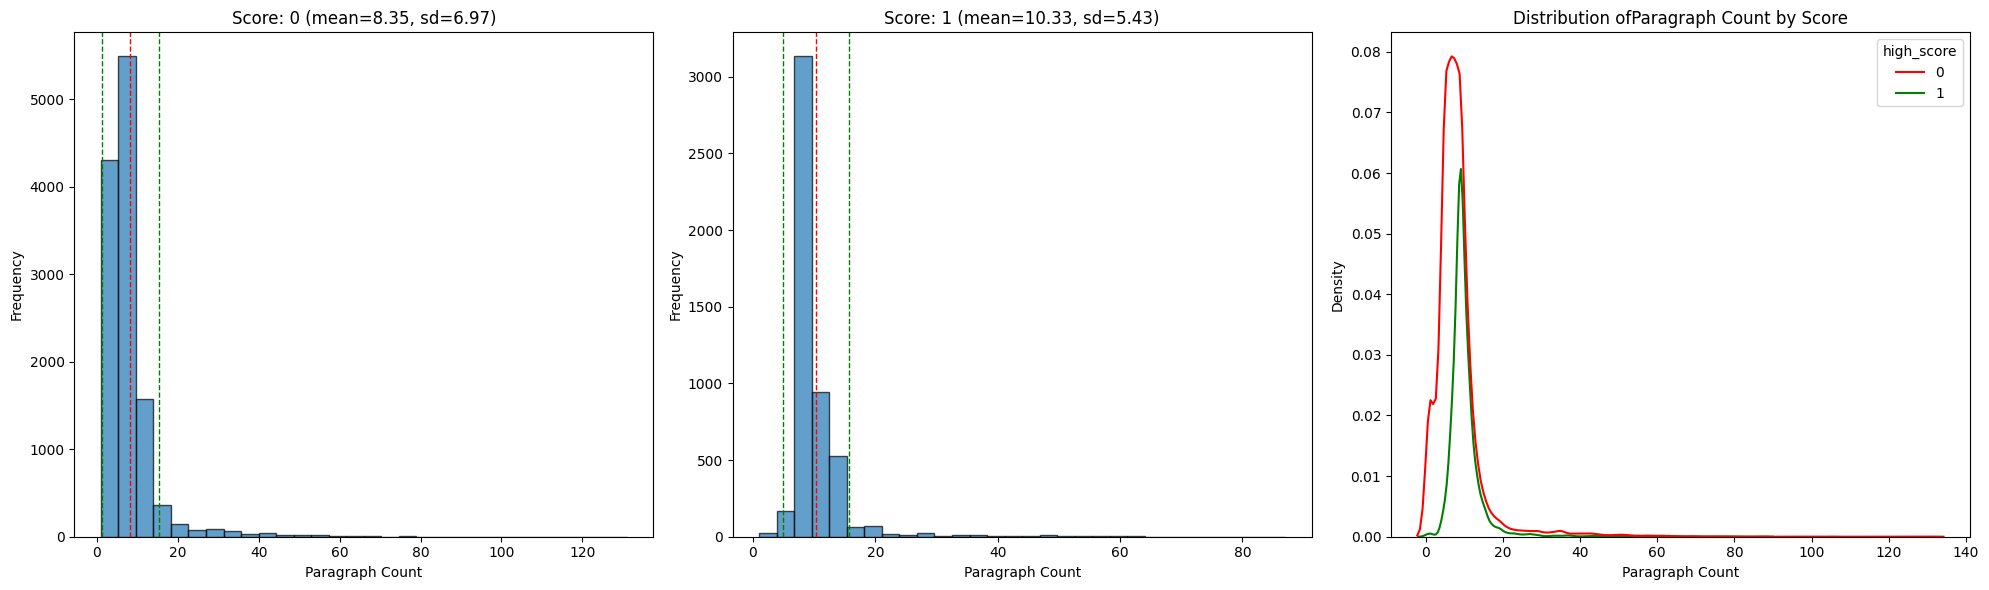

In [31]:
chart_high_score(data,'num_paragraphs', 'Paragraph Count')


Nhận xét:
- Số lượng câu trung bình của nhóm điểm 1, 2, 3 lớn hơn số lượng đoạn văn trung bình của nhóm điểm 4, 5, 6
- Tuy nhiên, về mặt phân phối thì số lượng này lại theo chiều ngược lại

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng đoạn văn nhiều hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng đoạn văn không nhiều hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng đoạn văn nhiều hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [32]:
accreditation(data, 'num_paragraphs',"greater")

t-statistic =  18.064360471489916
p-value =  1.402513240899831e-72
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


### Tính cảm xúc

In [33]:
from textblob import TextBlob
data['sentiment'] = data['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data.head()

,essay_id,full_text,score,high_score,len_text,word_count,sentence_count,num_paragraphs,sentiment
0,000d118,Many people have car where they live. The thin...,3,0,2677,498,13,1,0.179020
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669,332,21,9,0.101786
2,001ab80,People always wish they had the same technolog...,4,1,3077,550,24,7,0.168435
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701,451,20,9,0.094291
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208,373,15,11,0.170952


In [34]:
data['sentiment'].describe()

count    17307.000000
mean         0.139926
std          0.100875
min         -0.365189
25%          0.076935
50%          0.135237
75%          0.197590
max          0.612500
Name: sentiment, dtype: float64

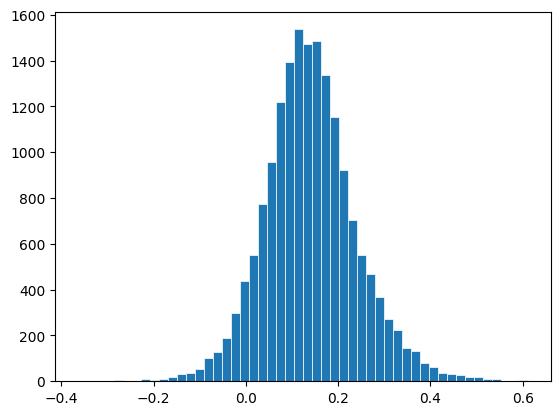

In [35]:
plt.hist(data['sentiment'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()

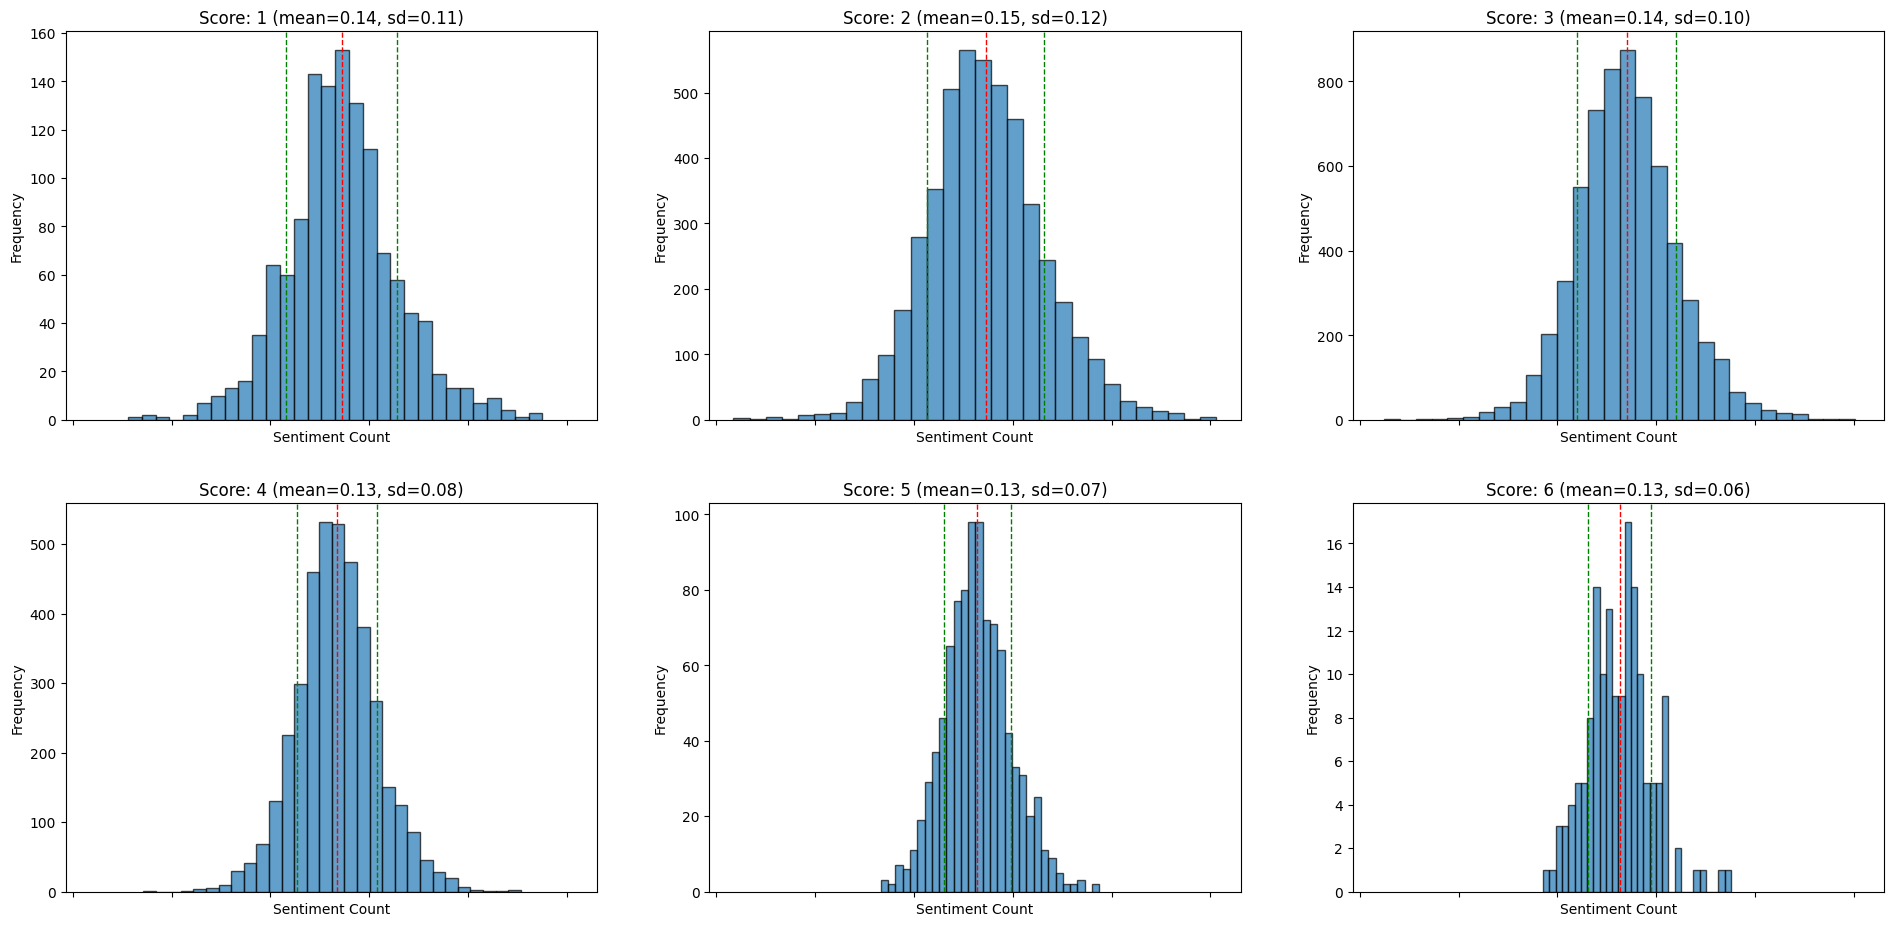

In [36]:
histogram_each_score(data, 'sentiment', 'Sentiment Count')

Nhận xét
- Giá trị độ cảm xúc trung bình của các bài đạt điểm 4, 5, 6 đều bằng nhau là 0.13
- Vì vậy, ta có thể sử dụng cột `high_score` để khám phá tiếp về độ cảm xúc của các bài văn

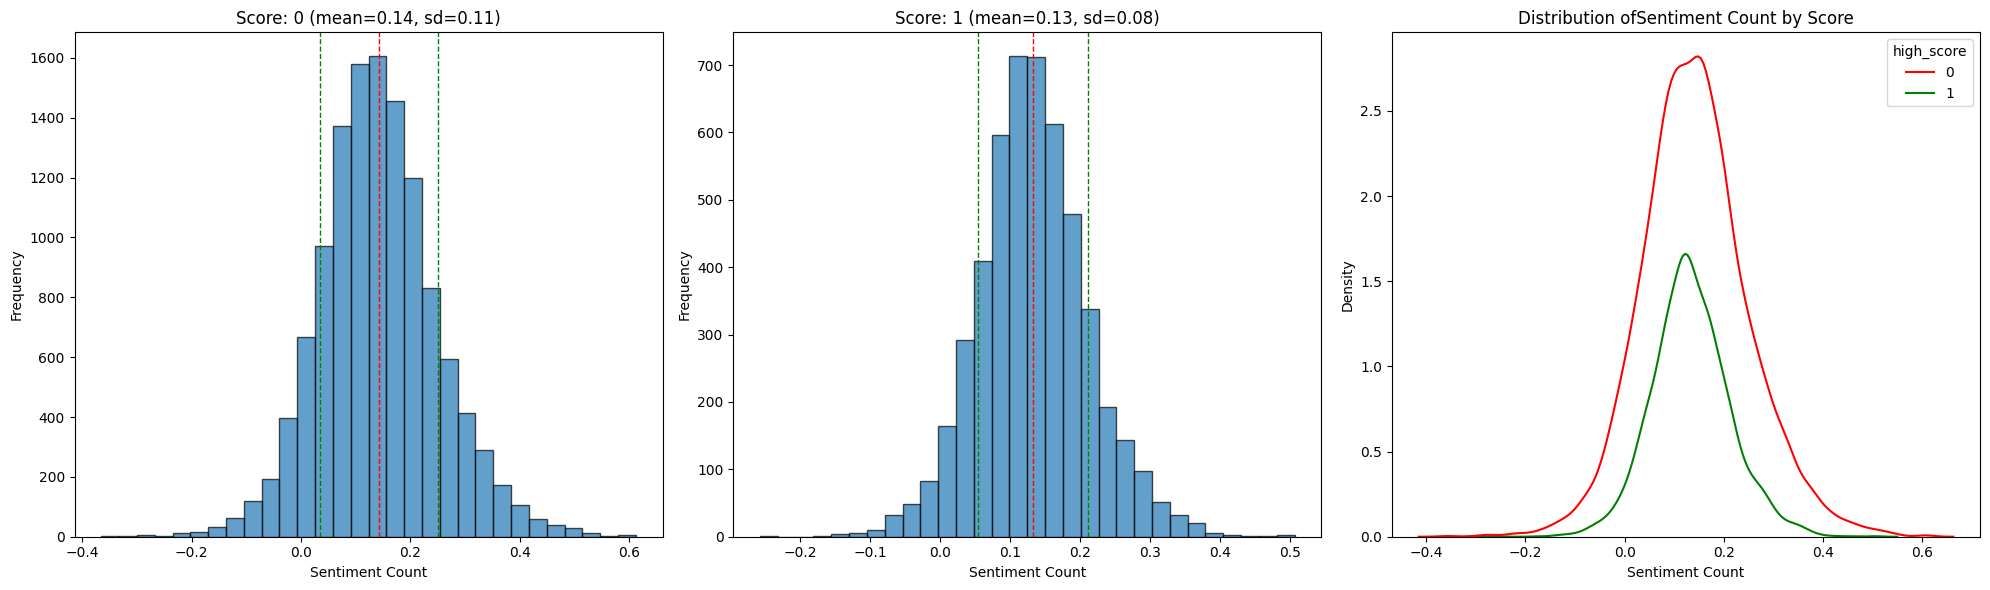

In [37]:
chart_high_score(data,'sentiment', 'Sentiment Count')


Nhận xét:
- Giá trị độ cảm xúc trung bình của nhóm điểm 1, 2, 3 lớn hơn giá trị độ cảm xúc trung bình của nhóm điểm 4, 5, 6
- Tuy nhiên, về mặt phân phối thì số lượng này lại theo chiều ngược lại

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có giá trị độ cảm xúc nhiều hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có giá trị độ cảm xúc không lớn hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có giá trị độ cảm xúc lớn hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [38]:
accreditation(data, 'sentiment',"greater")

t-statistic =  -5.546413533180525
p-value =  0.9999999852071491
Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa 0.05


### Tính độ chủ quan

In [39]:
data['subjectivity'] = data['full_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
data.head()

,essay_id,full_text,score,high_score,len_text,word_count,sentence_count,num_paragraphs,sentiment,subjectivity
0,000d118,Many people have car where they live. The thin...,3,0,2677,498,13,1,0.179020,0.542236
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669,332,21,9,0.101786,0.444643
2,001ab80,People always wish they had the same technolog...,4,1,3077,550,24,7,0.168435,0.451264
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701,451,20,9,0.094291,0.555147
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208,373,15,11,0.170952,0.569127


In [40]:
data['subjectivity'].describe()

count    17307.000000
mean         0.490725
std          0.084788
min          0.000000
25%          0.435417
50%          0.488690
75%          0.544124
max          0.913889
Name: subjectivity, dtype: float64

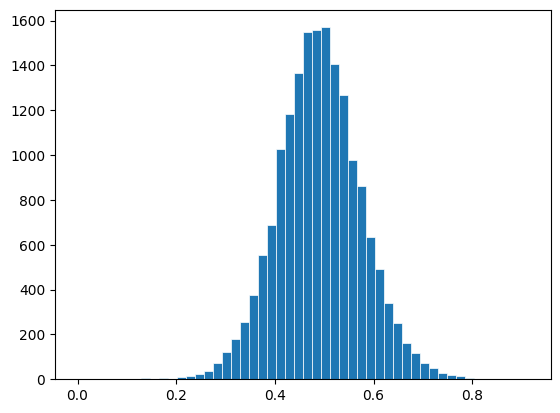

In [41]:
plt.hist(data['subjectivity'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()

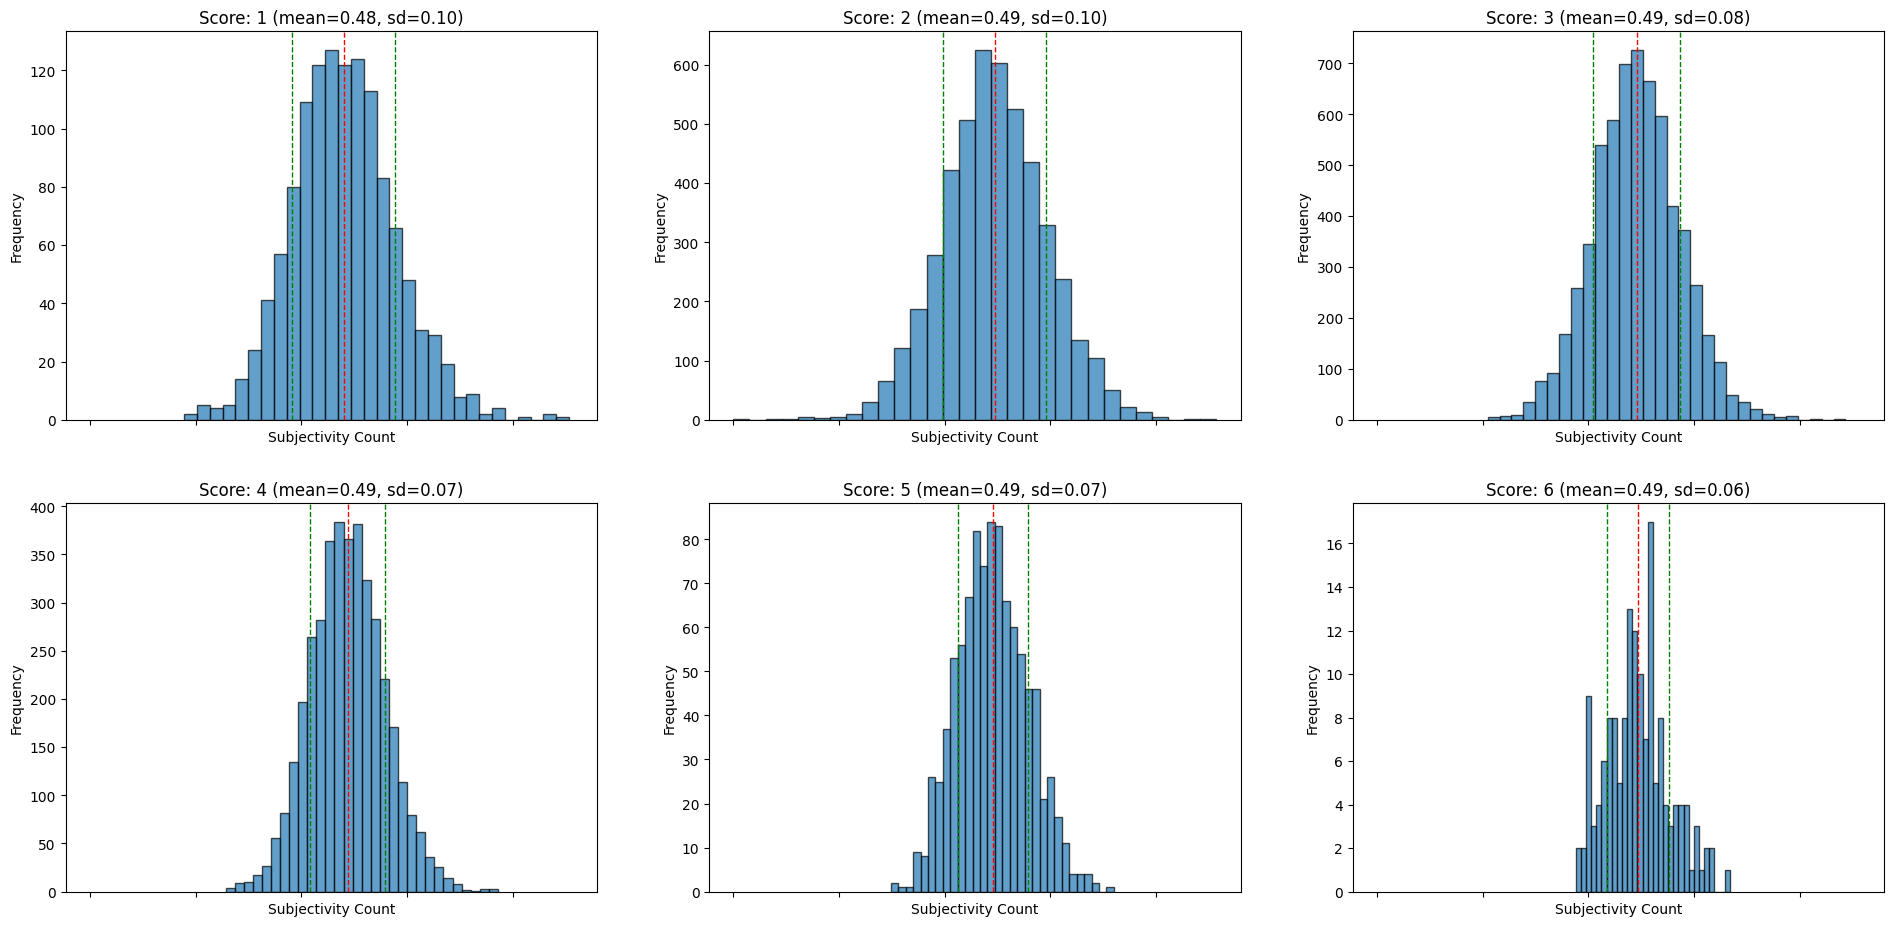

In [42]:
histogram_each_score(data, 'subjectivity', 'Subjectivity Count')

Nhận xét
- Giá trị độ tính chủ quan trung bình của các bài đạt điểm 2,3, 4, 5, 6 đều bằng nhau là 0.49


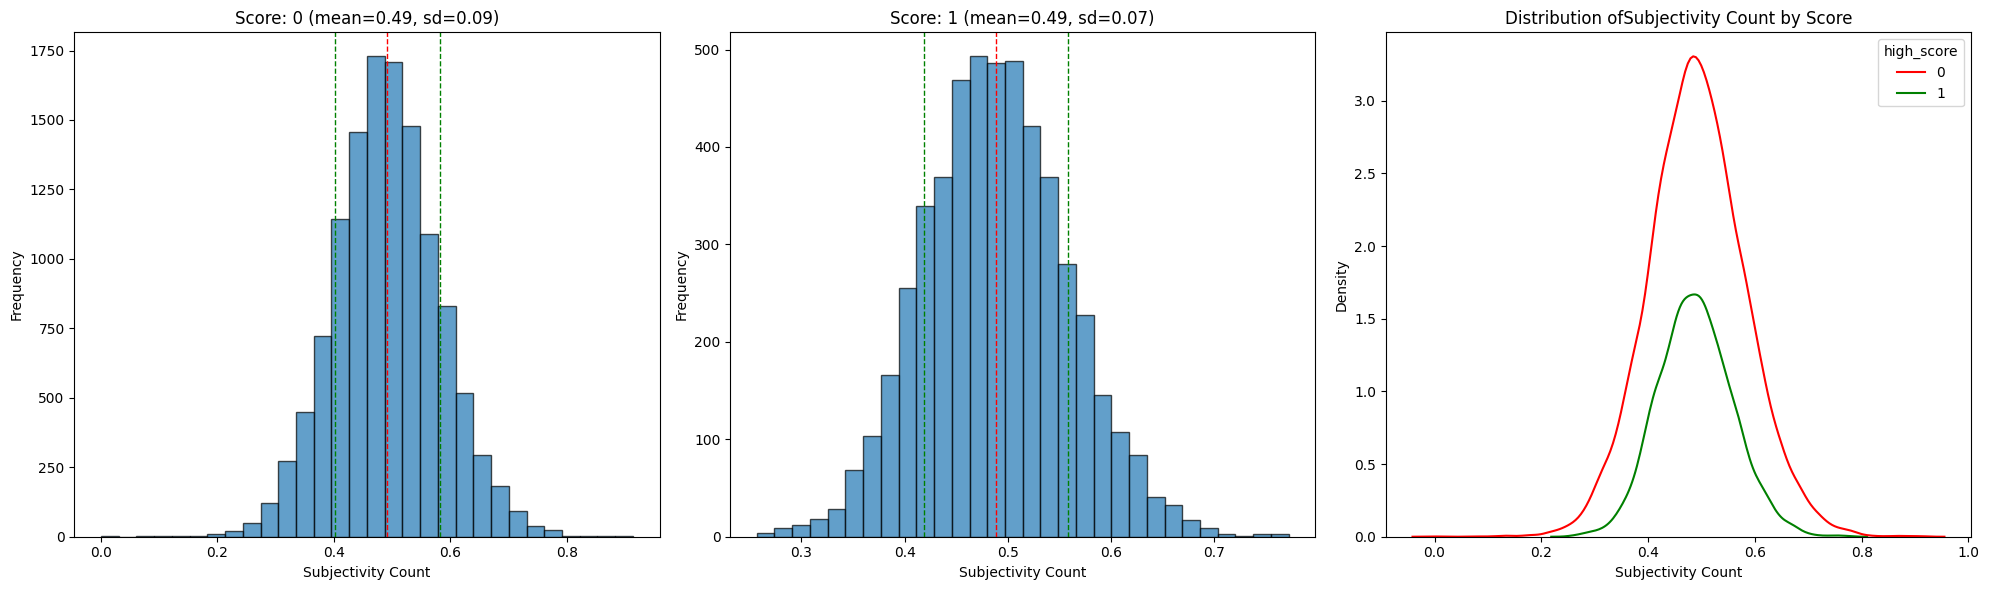

In [43]:
chart_high_score(data,'subjectivity', 'Subjectivity Count')


Nhận xét:
- Giá trị độ chủ quan trung bình của nhóm điểm 1, 2, 3 bằng với độ chủ quan trung bình của nhóm điểm 4, 5, 6
- Tuy nhiên, về mặt phân phối thì độ chủ quan trung bình của nhóm điểm 1, 2, 3 lại cao hơn độ chủ quan trung bình của nhóm điểm 4, 5, 6

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có độ chủ quan trung bình bằng các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có độ chủ quan không bằng các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có độ chủ quan bằng các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [44]:
accreditation(data, 'subjectivity',"two-sided")

t-statistic =  -2.0846528671970592
p-value =  0.03711544693113558
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


In [45]:
from scipy import stats

t_statistic, p_value = stats.ttest_ind(data[data['high_score'] == 1]['subjectivity'], data[data['high_score'] == 0]['subjectivity'], alternative="less")

print("t-statistic = ", t_statistic)
print("p-value = ", p_value)

alpha = 0.05

if p_value <= alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic =  -2.0846528671970592
p-value =  0.01855772346556779
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


### Độ Độc đáo


In [46]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words)

data['lexical_diversity'] = data['full_text'].apply(lexical_diversity)
data.head(10)

,essay_id,full_text,score,high_score,len_text,word_count,sentence_count,num_paragraphs,sentiment,subjectivity,lexical_diversity
0,000d118,Many people have car where they live. The thin...,3,0,2677,498,13,1,0.179020,0.542236,0.508032
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669,332,21,9,0.101786,0.444643,0.533133
2,001ab80,People always wish they had the same technolog...,4,1,3077,550,24,7,0.168435,0.451264,0.460000
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701,451,20,9,0.094291,0.555147,0.556541
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208,373,15,11,0.170952,0.569127,0.434316
5,0030e86,If I were to choose between keeping the electo...,4,1,2374,400,24,15,0.126214,0.461245,0.510000
6,0033037,The posibilty of a face reconizing computer wo...,2,0,1031,179,7,5,0.014286,0.437500,0.581006
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,0,1992,353,26,51,0.245500,0.439167,0.473088
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,0,1870,310,18,11,0.110292,0.597625,0.529032
9,0040e27,There are many reasons why you should join sea...,3,0,1521,280,23,9,0.284392,0.465675,0.507143


In [47]:
data['lexical_diversity'].describe()


count    17307.000000
mean         0.536895
std          0.074766
min          0.056763
25%          0.485106
50%          0.535836
75%          0.587275
max          0.801242
Name: lexical_diversity, dtype: float64

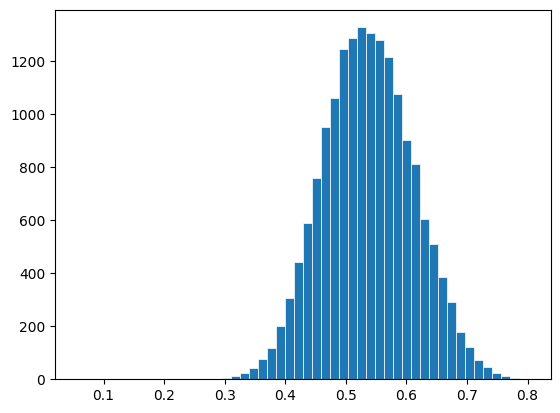

In [48]:
plt.hist(data['lexical_diversity'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()

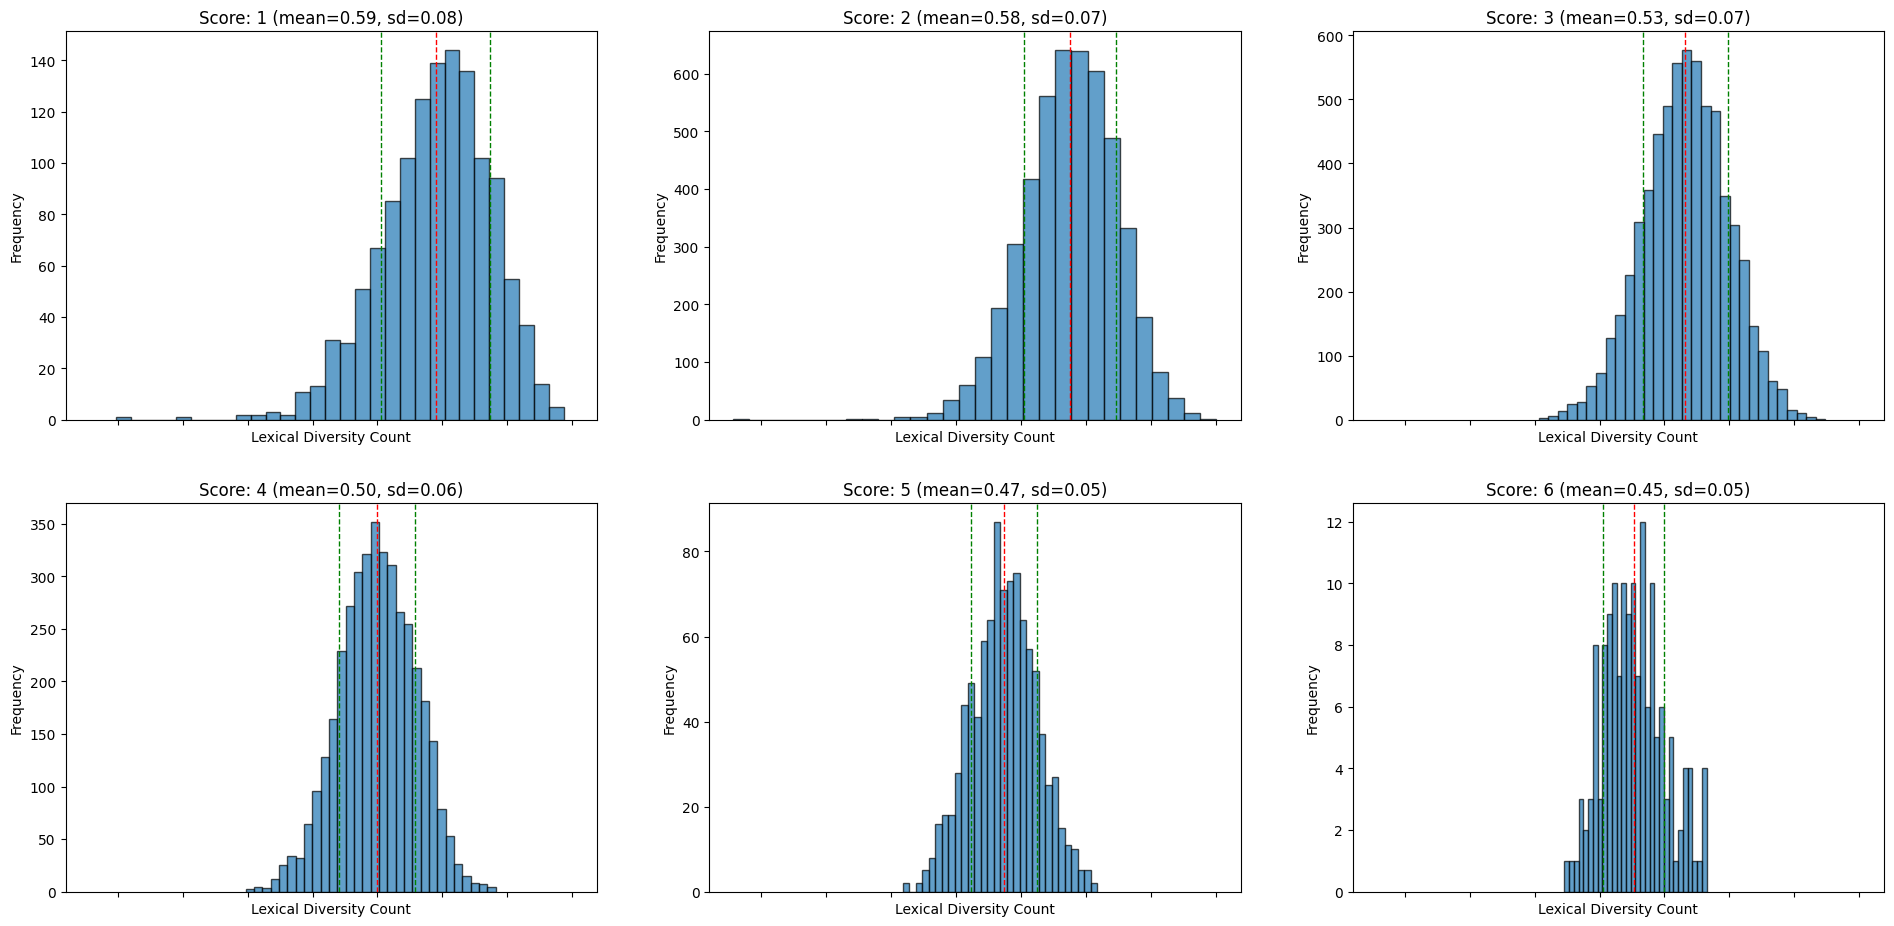

In [49]:
histogram_each_score(data, 'lexical_diversity', 'Lexical Diversity Count')

Nhận xét:
- Ta thấy độ độc đáo trung bình của điểm 1 2 3 đều lớn hơn điểm 4 5 6
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về độ độc đáo của các bài văn


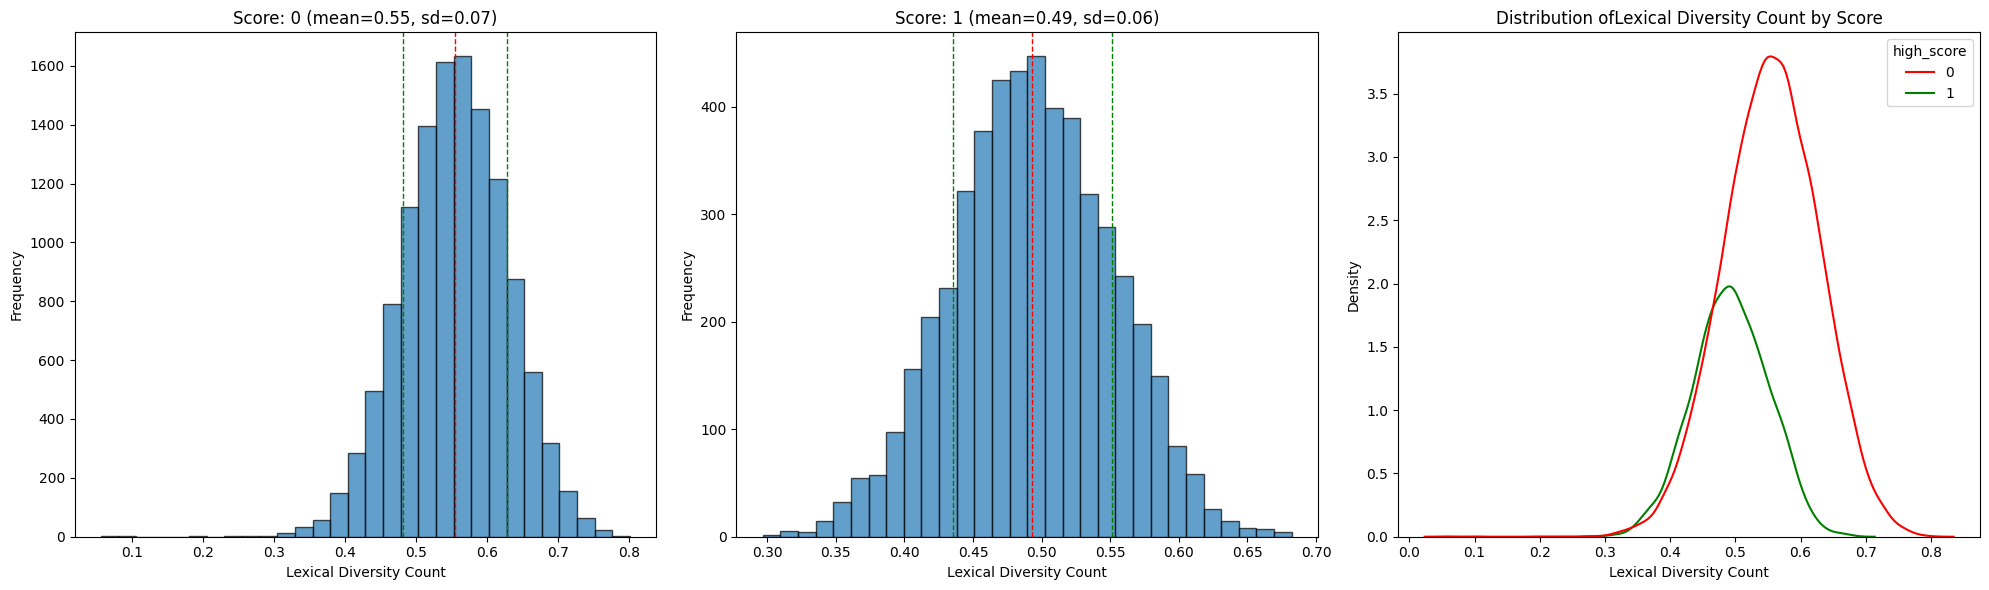

In [50]:
chart_high_score(data,'lexical_diversity', 'Lexical Diversity Count')

Nhận xét:
- Độ độc đáo trung bình của nhóm điểm 1, 2, 3 lớn hơn độ độc đáo trung bình của nhóm điểm 4, 5, 6
- Và về mặt phân phối thì điều này vẫn đúng

Tuy nhiên, ta vẫn tiến hành sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có độ độc đáo lớn hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có độ độc đáo không lớn hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [51]:
accreditation(data, 'lexical_diversity',"less")

t-statistic =  -53.329871734887796
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


### STOP WORDS

In [64]:
import string
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def cleaner(text):
    text = text.lower()
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

def cut_letters(text):
    text_list = text.split()
    return text_list

In [65]:
data['remove_stop_words'] = data['full_text'].apply(cleaner)
data['remove_stop_words'] = data['remove_stop_words'].apply(cut_letters)
data.head()

,essay_id,full_text,score,high_score,len_text,word_count,sentence_count,num_paragraphs,sentiment,subjectivity,lexical_diversity,remove_stop_words
0,000d118,Many people have car where they live. The thin...,3,0,2677,498,13,1,0.179020,0.542236,0.508032,"[people, car, live, thing, dont, know, use, ca..."
1,000fe60,I am a scientist at NASA that is discussing th...,3,0,1669,332,21,9,0.101786,0.444643,0.533133,"[scientist, nasa, discussing, face, mars, expl..."
2,001ab80,People always wish they had the same technolog...,4,1,3077,550,24,7,0.168435,0.451264,0.460000,"[people, wish, technology, seen, movies, best,..."
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,2701,451,20,9,0.094291,0.555147,0.556541,"[heard, venus, planet, oxygen, earthquakes, er..."
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0,2208,373,15,11,0.170952,0.569127,0.434316,"[dear, state, senatorthis, letter, argue, favo..."


In [67]:
from tqdm import trange
from collections import Counter

corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['remove_stop_words'][i]
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17307/17307 [00:00<00:00, 96257.19it/s]


2823446

In [68]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('cars', 42344),
 ('people', 37967),
 ('car', 36631),
 ('venus', 32798),
 ('like', 23943),
 ('just', 21779),
 ('driverless', 19852),
 ('face', 18897),
 ('electoral', 16419),
 ('think', 16222)]

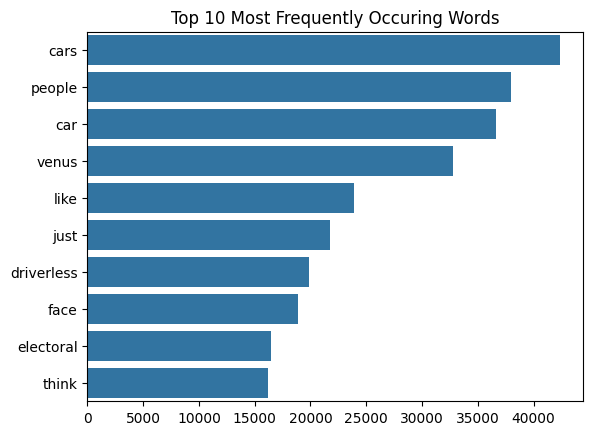

In [76]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

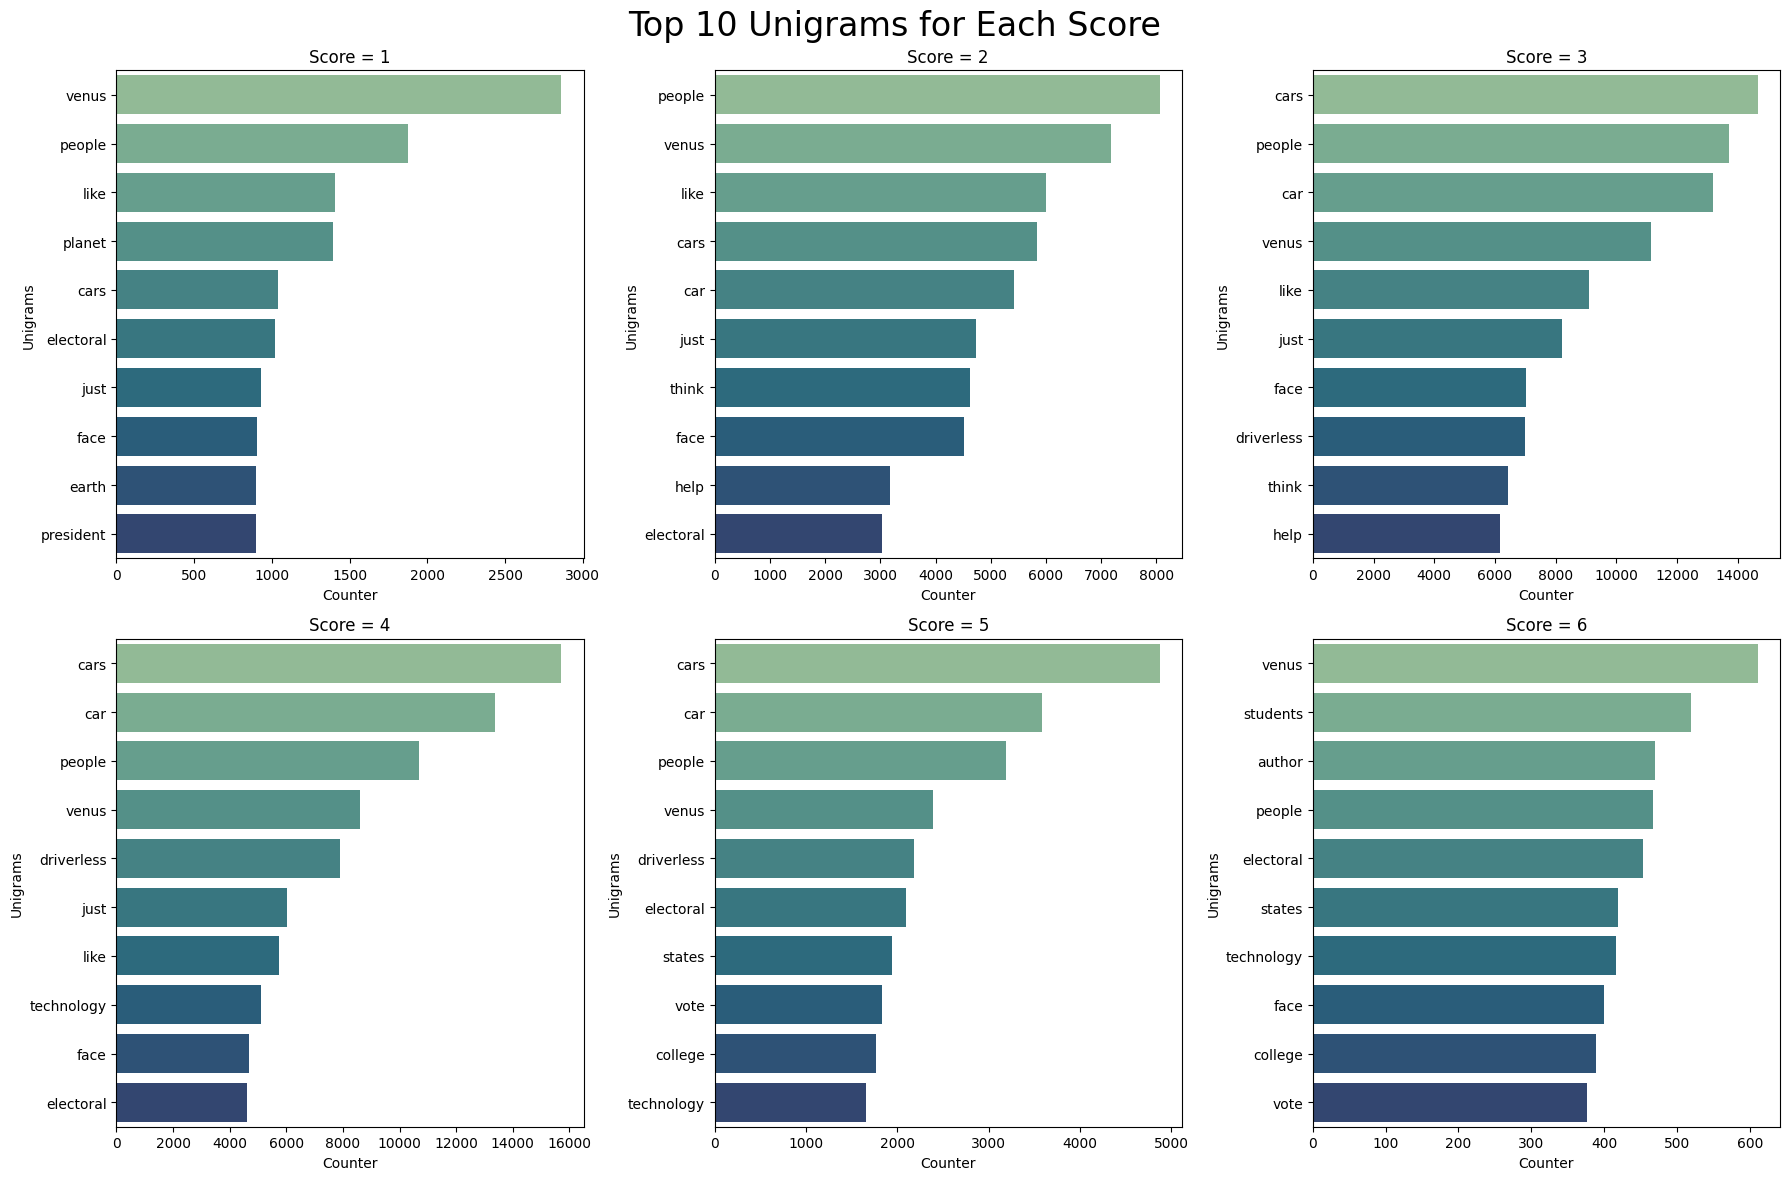

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for score in range(1, 7):
    # Lấy văn bản cho mức điểm cụ thể
    score_texts = data[data['score'] == score]['remove_stop_words']
    # Gộp tất cả văn bản lại
    combined_text = " ".join(" ".join(words) for words in score_texts)
    # Đếm tần suất từ
    word_counts = Counter(combined_text.split())
    # Lấy 10 từ phổ biến nhất
    most_common = word_counts.most_common(10)

    if most_common:  # Kiểm tra nếu most_common không trống
        words, freq = zip(*most_common)
        top_unigrams = pd.DataFrame(most_common, columns=['Unigrams', 'Counter'])

        sns.barplot(data=top_unigrams, x='Counter', y='Unigrams', palette='crest', ax=axes[score-1])
        axes[score-1].set_title(f"Score = {score}")

fig.suptitle('Top 10 Unigrams for Each Score', fontsize=24)
plt.tight_layout()
plt.show()

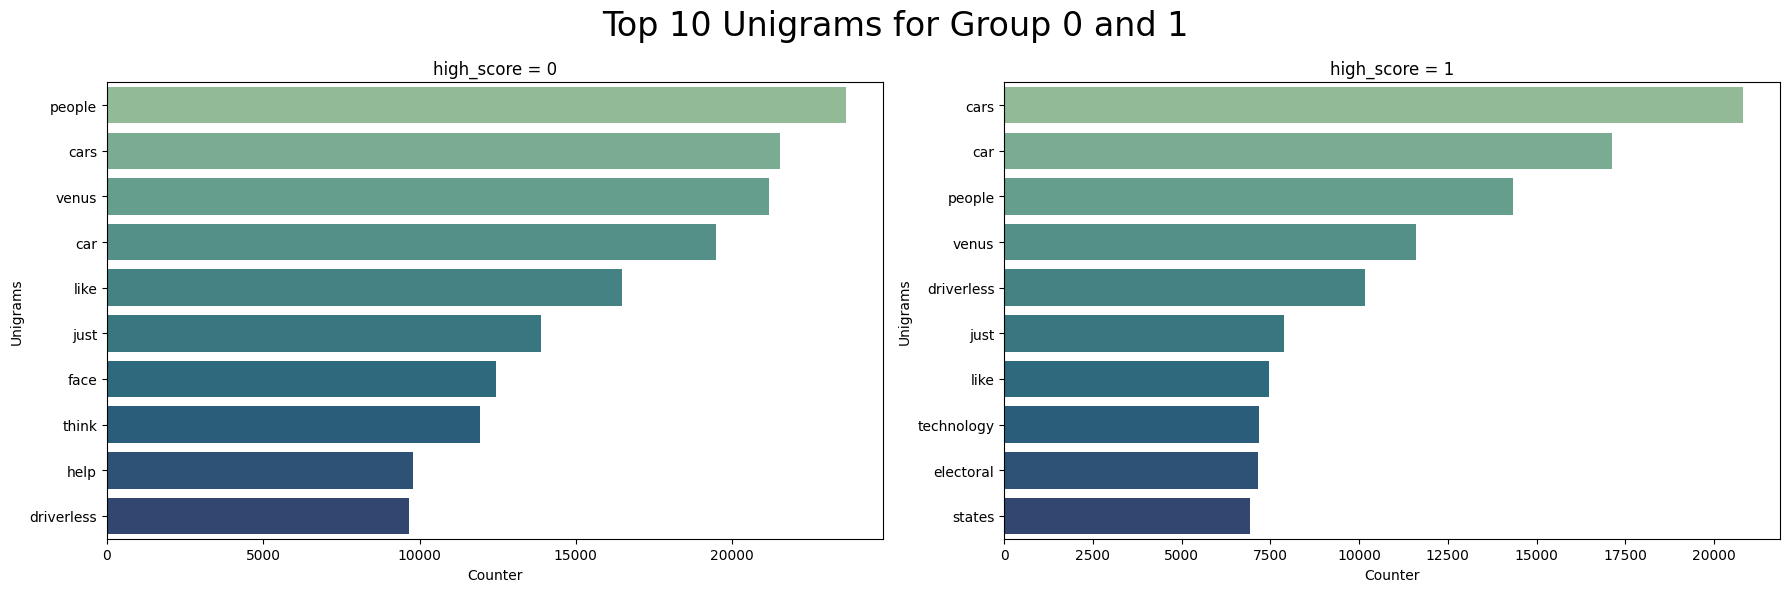

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Lặp qua hai mức điểm 0 và 1
for idx, score in enumerate([0, 1]):
    # Lấy văn bản cho mức điểm cụ thể
    score_texts = data[data['high_score'] == score]['remove_stop_words']
    # Gộp tất cả văn bản lại
    combined_text = " ".join(" ".join(words) for words in score_texts)
    # Đếm tần suất từ
    word_counts = Counter(combined_text.split())
    # Lấy 10 từ phổ biến nhất
    most_common = word_counts.most_common(10)

    if most_common:  # Kiểm tra nếu most_common không trống
        words, freq = zip(*most_common)
        top_unigrams = pd.DataFrame(most_common, columns=['Unigrams', 'Counter'])

        sns.barplot(data=top_unigrams, x='Counter', y='Unigrams', palette='crest', ax=axes[idx])
        axes[idx].set_title(f"high_score = {score}")

fig.suptitle('Top 10 Unigrams for Group 0 and 1', fontsize=24)
plt.tight_layout()
plt.show()